In [1]:
from ultralytics import YOLO
import torch
import cv2
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

/home/alber/anaconda3/envs/masters_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
model = YOLO("yolov8n-pose.pt")
model = model.to(device)

In [474]:
video_path = "../inference/video/panel_discussion_2.webm"
video_path = "../inference/video/dance_1.webm"
video_path = "../inference/video/YSU_20_sec.webm"
video_path = "../inference/video/one_min_ysu.webm"

In [475]:
results = model.track(video_path,show=True,save=True,save_dir='runs')



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/322) /home/alber/Desktop/DSB3/behavior-tracking-with-landmarks/src/../inference/video/one_min_ysu.webm: 480x640 6 persons, 14.4ms
video 1/1 (frame 2/322) /home/alber/Desktop/DSB3/behavior-tracking-with-landmarks/src/../inference/video/one_min_ysu.webm: 480x640 6 persons, 8.2ms
video 1/1 (frame 3/322) /home/alber/Desktop/DSB3/behavior-tracking-with-landmarks/src/../inference/video/one_min_ysu.webm: 480x640 6 persons, 10.8ms
video 1/1 

## cord funct

In [479]:

import cv2
import numpy as np
import pandas as pd
import os


def get_yolov8_pose_track_coords(pose_result,save_dir,file_name):


    landmarks_list = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", 
             "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", 
             "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]

    landmark_body_part = {'nose': "face",
                     'left_eye': "face",
                     'right_eye': "face",
                     'left_ear': "face",
                     'right_ear': "face",
                     'left_shoulder':"upper_limbs",
                     'right_shoulder': "upper_limbs",
                     'left_elbow': "upper_limbs",
                     'right_elbow': "upper_limbs",
                     'left_wrist': "upper_limbs",
                     'right_wrist': "upper_limbs",
                     'left_hip': "lower_limbs",
                     'right_hip': "lower_limbs",
                     'left_knee': "lower_limbs",
                     'right_knee': "lower_limbs",
                     'left_ankle': "lower_limbs",
                     'right_ankle': "lower_limbs"}
    
    key_landmarks = {'nose': "nose",
                     'left_eye': "left_eye",
                     'right_eye': "right_eye",
                     'left_ear': "left_ear",
                     'right_ear': "right_ear",
                     'left_shoulder':"left_hand",
                     'right_shoulder': "right_hand",
                     'left_elbow': "left_hand",
                     'right_elbow': "right_hand",
                     'left_wrist': "left_hand",
                     'right_wrist': "right_hand",
                     'left_hip': "left_foot",
                     'right_hip': "right_foot",
                     'left_knee': "left_foot",
                     'right_knee': "right_foot",
                     'left_ankle': "left_foot",
                     'right_ankle': "right_foot"}
    
    key_landmarks_as_body_part = {
                                'nose': "nose",
                                'left_eye': "eye",
                                'right_eye': "eye",
                                'left_ear': "ear",
                                'right_ear': "ear",
                                'left_shoulder':"hand",
                                'right_shoulder': "hand",
                                'left_elbow': "hand",
                                'right_elbow': "hand",
                                'left_wrist': "hand",
                                'right_wrist': "hand",
                                'left_hip': "foot",
                                'right_hip': "foot",
                                'left_knee': "foot",
                                'right_knee': "foot",
                                'left_ankle': "foot",
                                'right_ankle': "foot"}
    key_landmarks_as_body_part_2 = {
                                'nose': "face",
                                'left_eye': "face",
                                'right_eye': "face",
                                'left_ear': "face",
                                'right_ear': "face",
                                'left_shoulder':"hand",
                                'right_shoulder': "hand",
                                'left_elbow': "hand",
                                'right_elbow': "hand",
                                'left_wrist': "hand",
                                'right_wrist': "hand",
                                'left_hip': "foot",
                                'right_hip': "foot",
                                'left_knee': "foot",
                                'right_knee': "foot",
                                'left_ankle': "foot",
                                'right_ankle': "foot"}

    n_landmarks = len(landmarks_list)
    # cap = cv2.VideoCapture(video_path)

    n_frames = len(pose_result)

    # print(n_frames)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_color = (255, 0, 0)  
    thickness = 2
    
    
    full_cord_df = None
    
    
    dict_for_keypoints = {}
    
    for i_frame in range(n_frames):
    
    
        print(f"{'-'*30} FRAME {i_frame+1}/{n_frames} {'-'*30}")
        # plt.figure(figsize=(15,150))
    
    
        # get the frame
        result = pose_result[i_frame]
    
        orig_image = result.orig_img.copy() # get original image
        boxes = result.boxes # get bounding boxes
        keypoints = result.keypoints
    
        n_objects = len(result)
        
        for i_obj in range(n_objects):
    
            box = boxes[i_obj]
            keypoint = keypoints[i_obj]
    
            cls = int(box.cls.item())
            ID = int(box.id.item())
    
            box_x_min,box_y_min,box_x_max,box_y_max = box.xyxy.cpu().numpy()[0].astype(int)
    
            orig_image = cv2.rectangle(orig_image,(box_x_min,box_y_min),(box_x_max,box_y_max),(0,255,0),2)
            orig_image = cv2.putText(orig_image,"ID: "+str(ID),(box_x_min,box_y_min-5),font,font_scale,font_color,thickness)
    
            keypoint_coords = keypoint.xy.cpu().numpy()[0]
    
            # store keypoints in a dictionary to analyse movements
            # if id is not in the dict, add
    
            # id_dict_key = list(dict_for_keypoints.keys())
    
            # if ID not in id_dict_key:
    
                # print("Not")
                # print(landmarks_dict)
                # dict_for_keypoints[ID] = {landmarks_list[i]:[] for i in range(n_landmarks)}.copy()
                # dict_for_keypoints[ID] = copy.deepcopy(landmarks_dict)
            
    
            for pose_i in range(n_landmarks):
    
                pose = keypoint_coords[pose_i]
    
                landmark = landmarks_list[pose_i]
    
                pose_x,pose_y = pose.astype(int)
    
                # if landmarks appears or not
                lanmark_appears = False if  np.all(pose==np.array([0,0])) else True
    
                # dict_for_keypoints[ID][landmark].append([pose_x,pose_y])
    
    
                orig_image = cv2.circle(orig_image,(pose_x,pose_y),5,(0,0,255),-1)
    
                body_part = landmark_body_part[landmark]
                
                
                key_landmark = key_landmarks[landmark]
                key_landmark_as_body_part = key_landmarks_as_body_part[landmark]
                key_landmark_as_body_part_2 = key_landmarks_as_body_part_2[landmark]
    
                inner_df = pd.DataFrame({"Frame":[i_frame],
                                         "ID":[ID],
                                         "Landmark":[landmark],
                                         "LandmarkApears": [lanmark_appears],
                                         "BodyPart":[body_part],
                                         "RightLeftKeyLandmark":[key_landmark],
                                         "KeyLandmark" : [key_landmark_as_body_part],
                                         "KeyLandmarkFace":[key_landmark_as_body_part_2],
                                         "Pose_X":[pose_x],
                                         "Pose_Y":[pose_y],
                                         "bbox_x_min":[box_x_min],
                                         "bbox_y_min":[box_y_min],
                                         "bbox_x_max":[box_x_max],
                                         "bbox_y_max":[box_y_max]
                                        })
    
                if full_cord_df is None:
                    full_cord_df = inner_df.copy()
    
                    continue
    
                full_cord_df = pd.concat([full_cord_df,inner_df])


    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        # full_cord_df.to_csv(os.path.join(save_dir,file_name),index=False)
        
    full_cord_df.to_csv(os.path.join(save_dir,file_name),index=False)
    
    return full_cord_df
        

## Calc functions

In [7]:
# df = get_yolov8_pose_track_coords(results,save_dir="coord_data/",file_name="yolov8_pose_tracking_ysu_updated.csv")
# df = pd.read_csv("./coord_data/yolov8_pose_tracking_dance_1.csv")
# df = pd.read_csv("./coord_data/yolov8_pose_tracking_ysu.csv")
df = pd.read_csv("./coord_data/yolov8_pose_tracking_ysu_updated.csv")
df_not_zero = df[df['LandmarkApears']]

In [8]:

def calculate_mean_and_pc(df,groupby,variables,main_by='ID',suffix=None,prefix=None):

    suffix = '' if suffix==None else suffix
    prefix = '' if prefix==None else prefix
    mean_pose_coord_changes = df.groupby(groupby)[variables].mean().add_prefix(suffix).add_prefix(prefix)
    next_columns = mean_pose_coord_changes.columns
    mean_pose_coord_changes = mean_pose_coord_changes.reset_index()
    
    p_change = mean_pose_coord_changes.groupby(main_by)\
                                    [next_columns].pct_change().add_prefix("P_Change_")

    # merge absolute mean and percent change together
    mean_pose_coord_changes = mean_pose_coord_changes.reset_index().merge(p_change.reset_index(),on='index').drop("index",axis=1)
    mean_pose_coord_changes.fillna(0,inplace=True)

    return mean_pose_coord_changes


def distance_between_keypoints(df,keypoints_1,keypoints_2):
    
    keypoint_1 = keypoints_1[0].split("_")[1]
    keypoint_2 = keypoints_2[0].split("_")[1]
    
    data = df[['Frame','ID','Landmark','Pose_X','Pose_Y']].copy()
    
    df_1 = data[data['Landmark'].isin(keypoints_1)].drop("Landmark",axis=1)
    df_2 = data[data['Landmark'].isin(keypoints_2)].drop("Landmark",axis=1)
    
    df_1 = df_1.groupby(['Frame','ID']).agg("mean").add_prefix(keypoint_1+"_mean_")
    
    x_1,y_1 = df_1.columns
    df_1.reset_index(inplace=True)
    
    df_2 = df_2.groupby(['Frame','ID']).agg("mean").add_prefix(keypoint_2+"_mean_")
    
    
    x_2,y_2 = df_2.columns
    df_2.reset_index(inplace=True)
    
    df_1_2 = df_1.merge(df_2,on=['Frame','ID'])
    
    dist_1 = 'Euclidean_'+keypoint_1+"_to_"+keypoint_2
    dist_2 = 'Manhattan_'+keypoint_1+"_to_"+keypoint_2
    
    df_1_2[dist_1] = round(np.sqrt((df_1_2[x_2]-df_1_2[x_1])**2 + (df_1_2[y_2]-df_1_2[y_1])**2))
    df_1_2[dist_2] = round(abs(df_1_2[x_2]-df_1_2[x_1]) + abs(df_1_2[y_2]-df_1_2[y_1]))
    
    df_1_2_pc_change = df_1_2.groupby("ID")[[dist_1,dist_2]].pct_change().add_prefix("p_change_").fillna(0)
    pc_change_columns = df_1_2_pc_change.columns
    
    df_1_2 = df_1_2.reset_index().merge(df_1_2_pc_change.reset_index(),on='index').drop("index",axis=1)
    
    df_1_2 = df_1_2[["Frame","ID",dist_1,dist_2]+list(pc_change_columns)]

    return df_1_2



def get_individual_patters(df):


    n_rows = df.shape[0]
    df.index = list(range(n_rows))


    """
    Calcuations for each id
    
    """

    # sort df just in case by frame and id
    df.sort_values(['Frame','ID'],inplace=True)

    # remove rows where any keypoit dit not occur

    df_not_zero = df[df['LandmarkApears']]

    # get the number of frames
    n_frames = df['Frame'].values[-1] + 1

    # unique ids
    unique_ids = df['ID'].unique()
    n_unique_ids = len(unique_ids)
    
    # total mean y and x pose coordiante changes for each frame, and also, perent change of these varaibles
    # =============================================================================================================#

    total_mean_pose_coord_changes = calculate_mean_and_pc(df_not_zero,['Frame','ID'],['Pose_X','Pose_Y'],prefix='Mean_',main_by='ID')
    total_mean_pose_coord_changes['KeyLandmarkFace'] = 'total'

    # change of each keypoint, each body part, left and right
    # =============================================================================================================#

    each_keypoint_mean_pose = calculate_mean_and_pc(df_not_zero,['Frame','ID','KeyLandmarkFace'],['Pose_X','Pose_Y']\
                                                    ,prefix='Mean_',main_by=['ID','KeyLandmarkFace'])


    # concat 

    total_mean_pose_coord_changes = total_mean_pose_coord_changes[each_keypoint_mean_pose.columns]
    individual_df = pd.concat([total_mean_pose_coord_changes,each_keypoint_mean_pose])

    # conver to long format
    individual_df = individual_df.melt(id_vars=["Frame","ID","KeyLandmarkFace"],
                                               value_vars=["Mean_Pose_X","Mean_Pose_Y","P_Change_Mean_Pose_X","P_Change_Mean_Pose_Y"],
                                               var_name='Metrics',
                                               value_name='Score')

    individual_df['Metrics'] = individual_df['KeyLandmarkFace'] + "_"+ individual_df['Metrics']
    individual_df.drop("KeyLandmarkFace",axis=1,inplace=True)



    # distances, variations
    # =============================================================================================================#

    # the mean point in a face


    # the distance between eyes and shoulders
    keypoints_1 = ['left_eye', 'right_eye']
    keypoints_2 = ['left_shoulder', 'right_shoulder']

    eye_shoulder_distance = distance_between_keypoints(df_not_zero,keypoints_1,keypoints_2)

    # convert to long
    eye_shoulder_distance = eye_shoulder_distance.melt(id_vars=['Frame','ID'],\
                           value_vars=['Euclidean_eye_to_shoulder','Manhattan_eye_to_shoulder','p_change_Euclidean_eye_to_shoulder',\
                                       'p_change_Manhattan_eye_to_shoulder'],
                          var_name='Metrics',
                          value_name='Score')

    # add to main df
    individual_df = pd.concat([individual_df,eye_shoulder_distance])

    

    # bboxes
    # =============================================================================================================#

    # the change of min and max coordinates of boundings boxes for each id in each frame,
    # this will show how person area, which is his body position change over time


    bbox_cols = ['bbox_x_min','bbox_y_min','bbox_x_max','bbox_y_max']
    df_bbox = df_not_zero[['Frame','ID']+bbox_cols].copy().drop_duplicates()
    
    # # area
    df_bbox['bbox_width'] = df_bbox['bbox_x_max']-df_bbox['bbox_x_min']
    df_bbox['bbox_height'] = df_bbox['bbox_y_max']-df_bbox['bbox_y_min']
    df_bbox['bbox_center_x'] = (df_bbox['bbox_width']/2).astype(int)
    df_bbox['bbox_center_y'] = (df_bbox['bbox_height']/2).astype(int)
    df_bbox['bbox_area'] = df_bbox['bbox_width']*df_bbox['bbox_height']

    df_bbox_pc = df_bbox.drop("Frame",axis=1).groupby("ID").agg("pct_change").add_prefix("p_change")
    df_bbox_pc.fillna(0,inplace=True)
    df_bbox = df_bbox.reset_index().merge(df_bbox_pc.reset_index(),on='index').drop("index",axis=1)
    df_bbox = df_bbox[['Frame','ID','bbox_center_x','bbox_center_y','bbox_area',\
                       'p_changebbox_center_x', 'p_changebbox_center_y','p_changebbox_area']]

    df_bbox = df_bbox.melt(id_vars = ['Frame','ID'],value_vars=['bbox_center_x','bbox_center_y','bbox_area',\
                       'p_changebbox_center_x', 'p_changebbox_center_y','p_changebbox_area'],
                           var_name='Metrics',value_name='Score')


    # return df_bbox

    # add
    # return individual_df
    individual_df = pd.concat([individual_df,df_bbox])

    # face to front
    # =============================================================================================================#

    face_to_front = df_not_zero[['Frame','ID','BodyPart']].copy()
    # compute number of times any body part fully can be seen
    face_to_front = face_to_front.groupby(['Frame','ID','BodyPart'])['BodyPart']\
                                    .count().to_frame().rename(columns={"BodyPart":"ActualCount"}).reset_index()

    # the counts that need to be appread to consider body part is fully visible
    body_parts_counts = {"face":5,
                        "lower_limbs":6,
                        "upper_limbs":6}

    face_to_front['InitialCount'] = face_to_front['BodyPart'].map(body_parts_counts)
    face_to_front['RatioOfAppearance'] = face_to_front['ActualCount']/face_to_front['InitialCount']

    # long
    face_to_front = face_to_front.melt(id_vars=['Frame','ID','BodyPart'],value_vars=['RatioOfAppearance'],var_name='Metrics',value_name='Score')
    face_to_front['Metrics'] = face_to_front['BodyPart'] + "_"+face_to_front['Metrics']
    face_to_front.drop("BodyPart",axis=1,inplace=True)

    # concat
    individual_df = pd.concat([individual_df,face_to_front])

    # individual_df = total_mean_pose_coord_changes.copy()
    # individual_df = individual_df.merge(eye_shoulder_distance,on=['Frame','ID'])
    # individual_df = individual_df.merge(df_bbox,on=['Frame','ID'])
    # individual_df = individual_df.merge(face_to_front,on=['Frame','ID'])
    

    return individual_df
    

    

def individual_report_new_version(df,x='Frame'):

    """
    Inidivudal result visualization
    """

    try:
        IDS = df.ID.unique()
    except:
        IDS = ['Total']
        
    for ID in IDS:

        try:
            id_df = df[df['ID'] == ID]
        except:
            id_df = df.copy()
    # 
        # break
    
        metrics = df['Metrics'].unique()
    
        n_metics = len(metrics)
        # landmarks = id_df['KeyLandmarkFace'].unique()
    
        # print(n_metics)
    
        size = int(n_metics/2)
        # break
    
        
    
        fig,axs = plt.subplots(8,4)
        fig.set_figheight(15)
        fig.set_figwidth(15)
        fig.suptitle("ID: " + str(ID) + " Pose coordinates changes over frames\n\n")
        axes = axs.flatten()
    
    
        ax_i = 0
        for i in range(len(axes)):
    
    
            try:
                metric = metrics[i]
            except:
                print("YES")
                break
    
            
            met_df = id_df[id_df['Metrics'] == metric].copy()
    
            ax = axes[i]
            ax.set_title(metric)
            
            ax.plot(met_df[x],met_df['Score'])
            ax.set_xlabel(x)
            ax.set_ylabel("Score")
        plt.tight_layout()
        plt.show()
    
        break


In [9]:
individual_df = get_individual_patters(df)
individual_df

,Frame,ID,Metrics,Score
0,0,1,total_Mean_Pose_X,580.250000
1,0,2,total_Mean_Pose_X,457.230769
2,0,3,total_Mean_Pose_X,509.615385
3,0,4,total_Mean_Pose_X,878.818182
4,0,5,total_Mean_Pose_X,538.153846
...,...,...,...,...
5825,321,9,lower_limbs_RatioOfAppearance,0.333333
5826,321,9,upper_limbs_RatioOfAppearance,1.000000
5827,321,11,face_RatioOfAppearance,1.000000
5828,321,11,lower_limbs_RatioOfAppearance,0.333333


In [34]:
individual_df_wide = individual_df.pivot_table(index=['Frame','ID'],values='Score',columns='Metrics').reset_index()
individual_df_wide.sort_values(['Frame',"ID"]).head(20)

Metrics,Frame,ID,Euclidean_eye_to_shoulder,Manhattan_eye_to_shoulder,bbox_area,bbox_center_x,bbox_center_y,face_Mean_Pose_X,face_Mean_Pose_Y,face_P_Change_Mean_Pose_X,...,p_change_Euclidean_eye_to_shoulder,p_change_Manhattan_eye_to_shoulder,p_changebbox_area,p_changebbox_center_x,p_changebbox_center_y,total_Mean_Pose_X,total_Mean_Pose_Y,total_P_Change_Mean_Pose_X,total_P_Change_Mean_Pose_Y,upper_limbs_RatioOfAppearance
0,0,1,22.0,28.0,16100.0,35.0,115.0,578.75,111.50,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,580.250000,183.375000,0.000000,0.000000,1.000000
1,0,2,24.0,28.0,11556.0,53.0,54.0,462.00,253.20,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,457.230769,289.230769,0.000000,0.000000,1.000000
2,0,3,23.0,32.0,14641.0,60.0,60.0,520.00,322.40,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,509.615385,362.076923,0.000000,0.000000,1.000000
3,0,4,27.0,34.0,7347.0,39.0,46.0,889.00,210.60,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,878.818182,238.181818,0.000000,0.000000,0.833333
4,0,5,20.0,20.0,16146.0,58.0,69.0,539.80,440.40,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,538.153846,479.230769,0.000000,0.000000,1.000000
5,0,6,25.0,28.0,7696.0,37.0,52.0,61.40,63.40,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,61.769231,92.769231,0.000000,0.000000,1.000000
6,1,1,22.0,28.0,16100.0,35.0,115.0,579.00,111.50,0.000432,...,0.000000,0.000000,0.000000,0.000000,0.000000,580.375000,183.500000,0.000215,0.000682,1.000000
7,1,2,24.0,28.0,11556.0,53.0,54.0,462.00,253.20,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,457.076923,289.153846,-0.000336,-0.000266,1.000000
8,1,3,24.0,33.0,14884.0,61.0,61.0,520.40,322.60,0.000769,...,0.043478,0.031250,0.016597,0.016667,0.016667,509.538462,362.307692,-0.000151,0.000637,1.000000
9,1,4,26.0,33.0,7347.0,39.0,46.0,888.80,210.60,-0.000225,...,-0.037037,-0.029412,0.000000,0.000000,0.000000,878.818182,238.000000,0.000000,-0.000763,0.833333


In [35]:
individual_df

,Frame,ID,Metrics,Score
0,0,1,total_Mean_Pose_X,580.250000
1,0,2,total_Mean_Pose_X,457.230769
2,0,3,total_Mean_Pose_X,509.615385
3,0,4,total_Mean_Pose_X,878.818182
4,0,5,total_Mean_Pose_X,538.153846
...,...,...,...,...
5825,321,9,lower_limbs_RatioOfAppearance,0.333333
5826,321,9,upper_limbs_RatioOfAppearance,1.000000
5827,321,11,face_RatioOfAppearance,1.000000
5828,321,11,lower_limbs_RatioOfAppearance,0.333333


In [39]:
individual_df_wide.columns

Index(['Frame', 'ID', 'Euclidean_eye_to_shoulder', 'Manhattan_eye_to_shoulder',
       'bbox_area', 'bbox_center_x', 'bbox_center_y', 'face_Mean_Pose_X',
       'face_Mean_Pose_Y', 'face_P_Change_Mean_Pose_X',
       'face_P_Change_Mean_Pose_Y', 'face_RatioOfAppearance',
       'foot_Mean_Pose_X', 'foot_Mean_Pose_Y', 'foot_P_Change_Mean_Pose_X',
       'foot_P_Change_Mean_Pose_Y', 'hand_Mean_Pose_X', 'hand_Mean_Pose_Y',
       'hand_P_Change_Mean_Pose_X', 'hand_P_Change_Mean_Pose_Y',
       'lower_limbs_RatioOfAppearance', 'p_change_Euclidean_eye_to_shoulder',
       'p_change_Manhattan_eye_to_shoulder', 'p_changebbox_area',
       'p_changebbox_center_x', 'p_changebbox_center_y', 'total_Mean_Pose_X',
       'total_Mean_Pose_Y', 'total_P_Change_Mean_Pose_X',
       'total_P_Change_Mean_Pose_Y', 'upper_limbs_RatioOfAppearance'],
      dtype='object', name='Metrics')

In [41]:
# fig,ax = plt.subplots(4,4)

# fig.set_figwidth(15)
# fig.set_figheight(15)


# axes = ax.flatten()

# axes[0].plot(individual_df_wide['Frame'],individual_df_wide['total_Mean_Pose_X'])
# axes[0].plot(individual_df_wide['Frame'],individual_df_wide['total_Mean_Pose_Y'])

YES


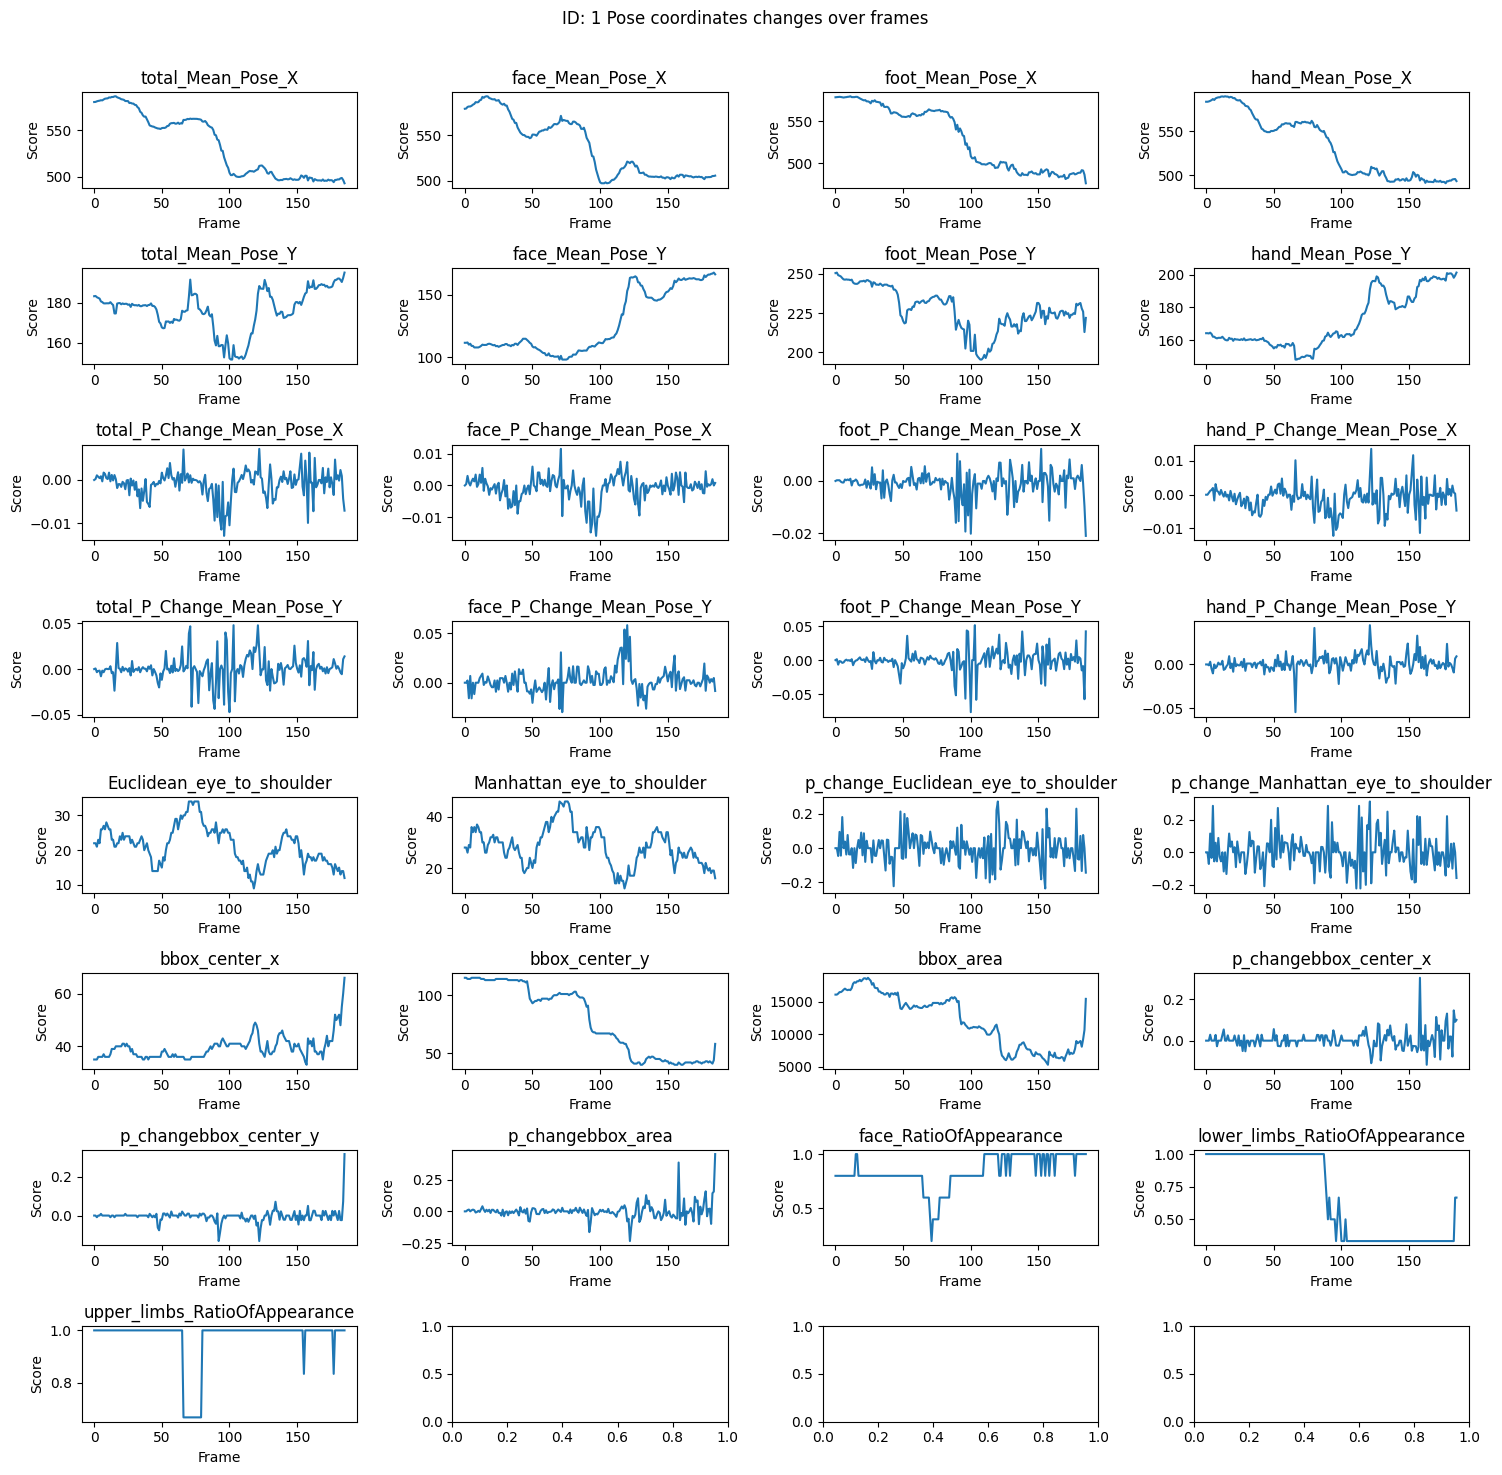

In [10]:
individual_report_new_version(individual_df)

## Each frame functions

In [4]:
def get_each_frame_patters(inidividual_patterns):


    each_frame = inidividual_patterns.copy()

    each_frame = each_frame.groupby(['Frame','Metrics'])['Score'].mean().to_frame().reset_index().sort_values(['Frame','Metrics'])

    return each_frame


def get_each_id_patters(inidividual_patterns):


    each_id = inidividual_patterns.copy()

    each_id = each_id.groupby(['ID','Metrics'])['Score'].mean().to_frame().reset_index().sort_values(['ID','Metrics'])

    return each_id


# def get_each_id_patterns = 

In [5]:
frame_df = get_each_frame_patters(individual_df)
id_df = get_each_id_patters(individual_df)


NameError: name 'individual_df' is not defined

YES


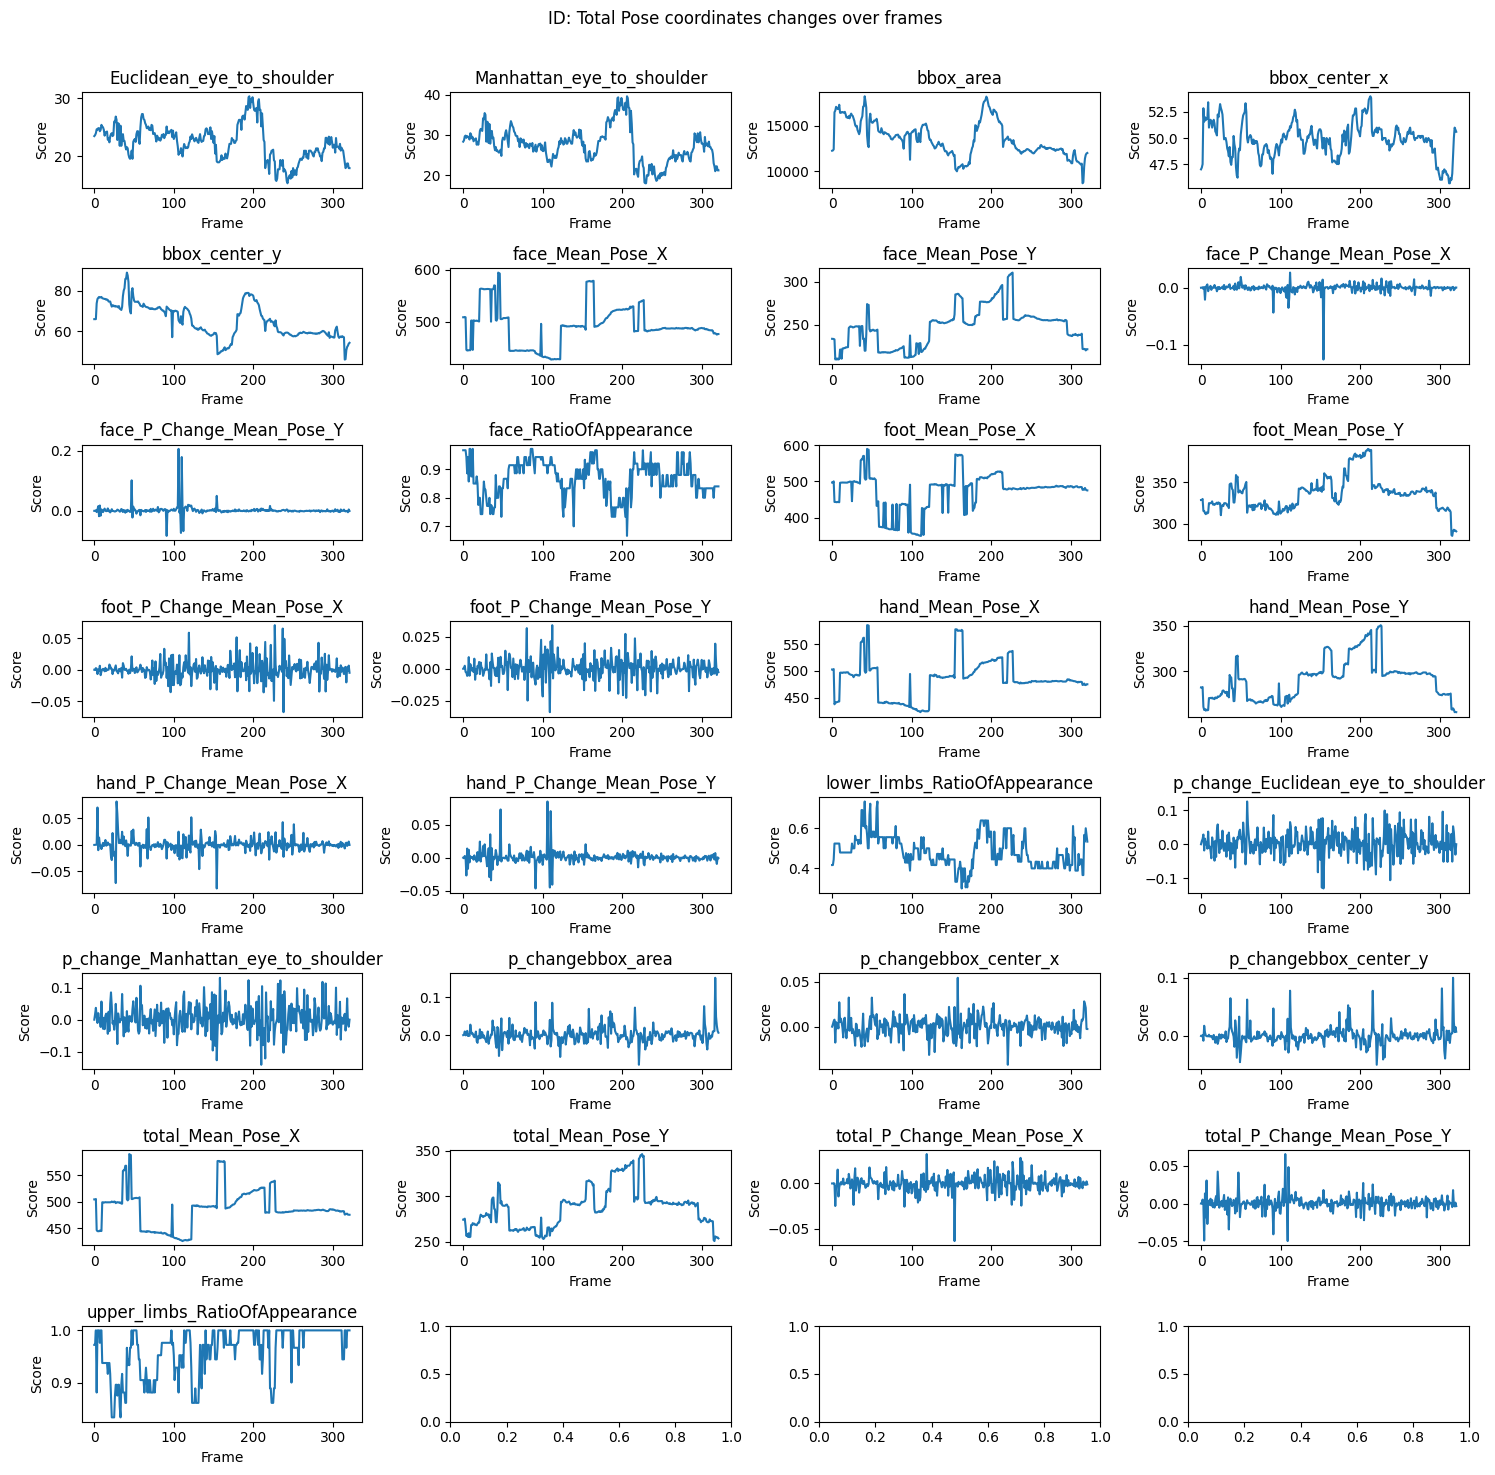

In [496]:
individual_report_new_version(frame_df)

In [506]:

def each_id_plot(df,x='Frame'):

    """
    Inidivudal result visualization
    """
    id_df = df.copy()
    
    metrics = df['Metrics'].unique()
    
    n_metics = len(metrics)
    # landmarks = id_df['KeyLandmarkFace'].unique()
    
    # print(n_metics)
    
    size = int(n_metics/2)
    # break
    
    
    
    fig,axs = plt.subplots(8,4)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    fig.suptitle("ID: " + str(ID) + " Pose coordinates changes over frames\n\n")
    axes = axs.flatten()
    
    
    ax_i = 0
    for i in range(len(axes)):
    
    
        try:
            metric = metrics[i]
        except:
            print("YES")
            break
    
        
        met_df = id_df[id_df['Metrics'] == metric].copy()
    
        ax = axes[i]
        ax.set_title(metric)
        
        ax.bar(met_df[x],met_df['Score'])
        ax.set_xlabel(x)
        ax.set_ylabel("Score")
    plt.tight_layout()
    plt.show()
    


YES


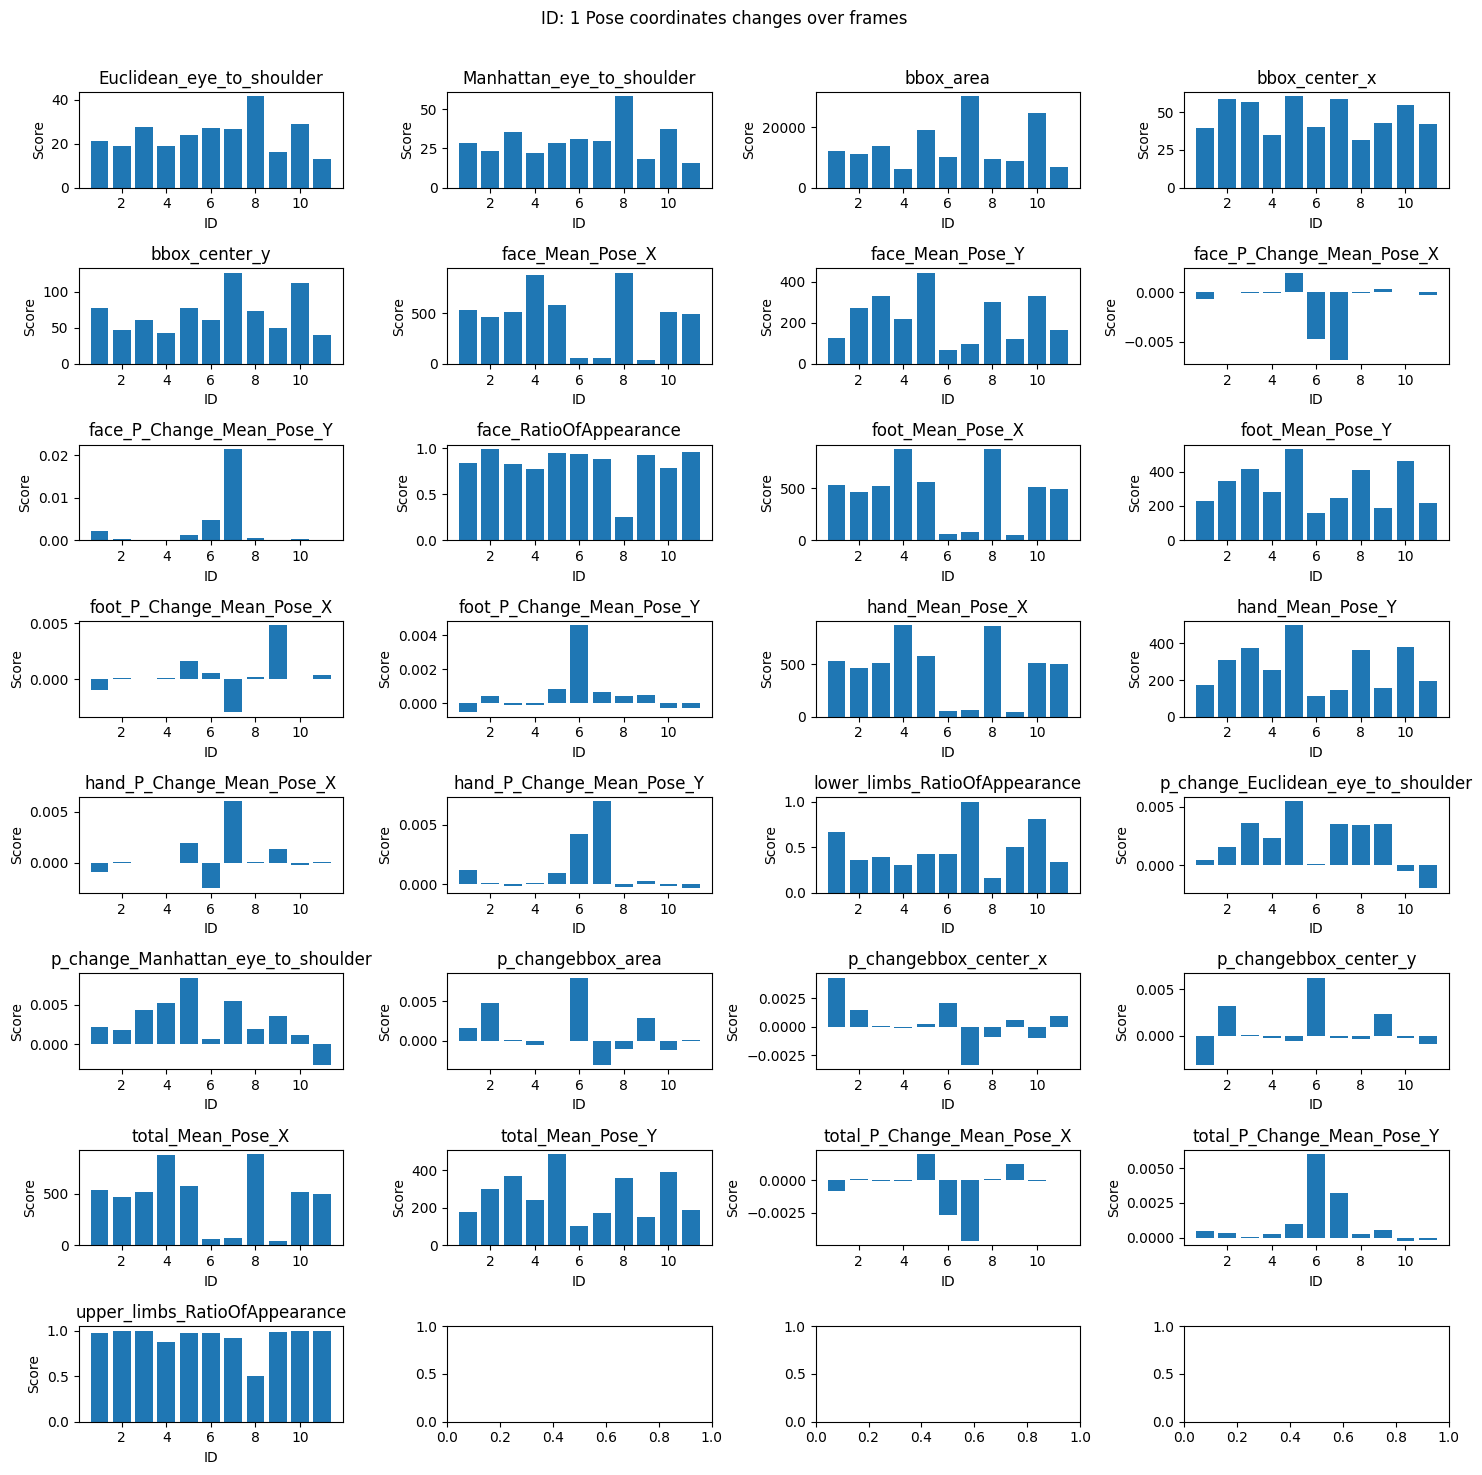

In [507]:
each_id_plot(id_df,'ID')

## Results

In [222]:
output

,Frame,ID,TotalMean_Pose_X,TotalMean_Pose_Y,P_Change_TotalMean_Pose_X,P_Change_TotalMean_Pose_Y,KeyLandmarkFace,BodyPartMean_Pose_X,BodyPartMean_Pose_Y,P_Change_BodyPartMean_Pose_X,...,Manhattan_eye_to_shoulder,p_change_Euclidean_eye_to_shoulder,p_change_Manhattan_eye_to_shoulder,p_changebbox_center_x,p_changebbox_center_y,p_changebbox_area,BodyPart,BodyPartActualCount,BodyPartInitialCount,BodyPartRatioOfAppearance
0,0,1,633.764706,277.705882,0.000000,0.000000,face,633.400000,136.400000,0.000000,...,60.0,0.0,0.0,0.000000,0.0,0.000000,face,5,5,1.0
1,0,1,633.764706,277.705882,0.000000,0.000000,face,633.400000,136.400000,0.000000,...,60.0,0.0,0.0,0.000000,0.0,0.000000,lower_limbs,6,6,1.0
2,0,1,633.764706,277.705882,0.000000,0.000000,face,633.400000,136.400000,0.000000,...,60.0,0.0,0.0,0.000000,0.0,0.000000,upper_limbs,6,6,1.0
3,0,1,633.764706,277.705882,0.000000,0.000000,foot,648.166667,436.500000,0.000000,...,60.0,0.0,0.0,0.000000,0.0,0.000000,face,5,5,1.0
4,0,1,633.764706,277.705882,0.000000,0.000000,foot,648.166667,436.500000,0.000000,...,60.0,0.0,0.0,0.000000,0.0,0.000000,lower_limbs,6,6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16546,613,3,190.764706,278.000000,-0.001232,0.000847,foot,187.333333,430.333333,-0.000889,...,74.0,0.0,0.0,0.010753,0.0,0.010753,lower_limbs,6,6,1.0
16547,613,3,190.764706,278.000000,-0.001232,0.000847,foot,187.333333,430.333333,-0.000889,...,74.0,0.0,0.0,0.010753,0.0,0.010753,upper_limbs,6,6,1.0
16548,613,3,190.764706,278.000000,-0.001232,0.000847,hand,188.000000,237.333333,0.000000,...,74.0,0.0,0.0,0.010753,0.0,0.010753,face,5,5,1.0
16549,613,3,190.764706,278.000000,-0.001232,0.000847,hand,188.000000,237.333333,0.000000,...,74.0,0.0,0.0,0.010753,0.0,0.010753,lower_limbs,6,6,1.0


In [15]:
df.head()

,Frame,ID,Landmark,LandmarkApears,BodyPart,RightLeftKeyLandmark,KeyLandmark,Pose_X,Pose_Y,bbox_x_min,bbox_y_min,bbox_x_max,bbox_y_max
0,0,1,nose,True,face,nose,nose,151,98,41,52,221,429
0,0,1,left_eye,True,face,eye,eye,156,90,41,52,221,429
0,0,1,right_eye,True,face,eye,eye,141,89,41,52,221,429
0,0,1,left_ear,False,face,ear,ear,0,0,41,52,221,429
0,0,1,right_ear,True,face,ear,ear,116,90,41,52,221,429


## Draft

In [50]:
dr_1 = df.groupby(['Frame','ID'],as_index=False)['Pose_X'].mean().sort_values(['Frame','ID'])

In [51]:
dr_2 = df.groupby(['ID','Frame'],as_index=False)['Pose_X'].mean().sort_values(['Frame','ID'])

In [52]:
dr = dr_1.merge(dr_2,on=['Frame','ID'])

In [55]:
(dr['Pose_X_x'] - dr['Pose_X_y']).sum()

0.0

In [30]:
df.tail()

,Frame,ID,Landmark,LandmarkApears,BodyPart,RightLeftKeyLandmark,KeyLandmark,KeyLandmarkFace,Pose_X,Pose_Y,bbox_x_min,bbox_y_min,bbox_x_max,bbox_y_max
31309,613,3,right_hip,True,lower_limbs,right_foot,foot,foot,159,320,93,113,281,583
31310,613,3,left_knee,True,lower_limbs,left_foot,foot,foot,231,430,93,113,281,583
31311,613,3,right_knee,True,lower_limbs,right_foot,foot,foot,140,434,93,113,281,583
31312,613,3,left_ankle,True,lower_limbs,left_foot,foot,foot,239,537,93,113,281,583
31313,613,3,right_ankle,True,lower_limbs,right_foot,foot,foot,135,541,93,113,281,583


In [31]:
frame_0 = df[df['Frame'] == 613].copy()
frame_0 = frame_0[['Pose_X','Pose_Y','Landmark','bbox_x_min','bbox_y_min','bbox_x_max','bbox_y_max']].drop_duplicates()


In [48]:
cap = cv2.VideoCapture(video_path)



while True:

    cat,frame = cap.read()


    if not cat:
        break

    image = deepcopy(frame)

    for bbox in frame_0.values:

        pose_x,pose_y,landmark,x_min,y_min,x_max,y_max = bbox

        cv2.rectangle(image,(x_min,y_min),(x_max,y_max),(244,0,0),2)
        cv2.circle(image, (pose_x,pose_y), 3, (255,255,255), -1)  # -1 means fill the circle
        cv2.putText(image,landmark,(pose_x,pose_y),cv2.FONT_HERSHEY_SIMPLEX,0.4,(255,255,255),1)


    # break
    

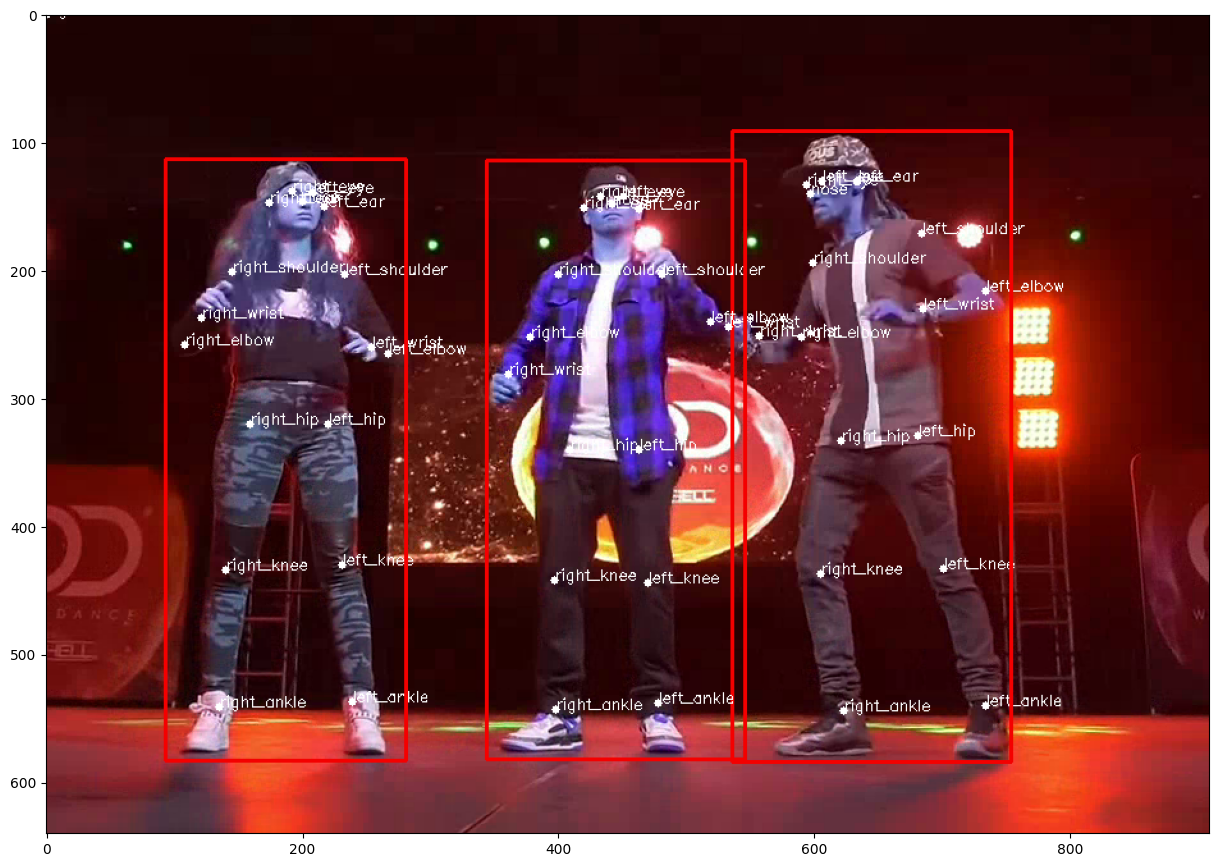

In [49]:
plt.figure(figsize=(15,15))
plt.imshow(image)